## Análise e Previsão Univariada de Séries Temporais: Temperatura em Itapeva-SP 01/2023 a 08/2024

##### Descrição dos dados:

- Acesso: https://portal.inmet.gov.br/dadoshistoricos
- Sobre: Temperatura na cidade de Itapeva-SP medidas entre 01/2023 a 08/2024

##### Importação Bibliotecas

In [65]:
import pandas as pd
import os
import chardet
from pathlib import Path 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose # Trabalhar com decomposição componentes Séries Temporais
from statsmodels.graphics.tsaplots import plot_acf # Plot da função de autocorrelação
from statsmodels.graphics.tsaplots import plot_pacf # Plot da função de autocorrelação parcial
import scipy.stats as stats # Plot do gráfico Q-QPlot (Ajuda para verificar se os dados aproximam de uma distribuição normal visualmente)
import statsmodels.api as sm # Plot do gráfico Q-QPlot
from statsmodels.tsa.stattools import adfuller # Testar se Série Temporal pode ser considerado estacionária
import numpy as np
from datetime import date

##### Listando e selecionando arquivos a serem carregados

In [66]:
list_file = os.listdir("../../base_projects/temperature_data_sp")
index_ = [i for i, item in enumerate(list_file) if item.startswith('INMET_SE_SP_A714_ITAPEVA')]

config_file = {}

for i, item_index in enumerate(index_):
    file_path = Path(f"../../base_projects/temperature_data_sp/{list_file[item_index]}")
    # Abrir o arquivo no modo binário para detecção de encoding
    with open(file_path, 'rb') as f:
        encoding = f"'{chardet.detect(f.read())['encoding']}'"
    
    config_file[i] = (item_index, list_file[item_index], encoding)

print(config_file)
#index_file = list_file.index('INMET_SE_SP_A771_SAO PAULO - INTERLAGOS_01-01-2023_A_31-12-2023.CSV')

{0: (0, 'INMET_SE_SP_A714_ITAPEVA_01-01-2019_A_31-12-2019.CSV', "'ISO-8859-1'"), 1: (1, 'INMET_SE_SP_A714_ITAPEVA_01-01-2024_A_31-08-2024.CSV', "'ISO-8859-1'"), 2: (2, 'INMET_SE_SP_A714_ITAPEVA_01-01-2023_A_31-12-2023.CSV', "'ISO-8859-1'"), 3: (3, 'INMET_SE_SP_A714_ITAPEVA_01-01-2021_A_31-12-2021.CSV', "'ISO-8859-1'"), 4: (4, 'INMET_SE_SP_A714_ITAPEVA_01-01-2022_A_31-12-2022.CSV', "'ISO-8859-1'"), 5: (5, 'INMET_SE_SP_A714_ITAPEVA_01-01-2020_A_31-12-2020.CSV', "'ISO-8859-1'")}


##### Carregamento e transformação dos dados

In [67]:
df = pd.DataFrame()

for i in range(0, len(config_file)):
    df_aux = pd.read_csv(
            f"../../base_projects/temperature_data_sp/{config_file[i][1]}",
            sep=";", 
            skiprows=8,
            encoding=config_file[i][2]
        )
    df = pd.concat([df, df_aux], ignore_index=True) 

df = df[~df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].isna()]
df = df[~df['Data'].isna()]
df = df[['Data', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']]
df.rename(columns={'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'Temperatura do Ar (°C)'}, inplace=True)
df

,Data,Temperatura do Ar (°C)
0,2019/01/01,"23,4"
1,2019/01/01,"22,4"
2,2019/01/01,"21,3"
3,2019/01/01,"20,7"
4,2019/01/01,"20,2"
...,...,...
49675,2020/12/31,"19,5"
49676,2020/12/31,"19,2"
49677,2020/12/31,"19,2"
49678,2020/12/31,"18,9"


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47266 entries, 0 to 49679
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Data                    47266 non-null  object
 1   Temperatura do Ar (°C)  47266 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [69]:
df['Data'] = pd.to_datetime(df['Data'], format='%Y/%m/%d')
df['Temperatura do Ar (°C)'] = (df['Temperatura do Ar (°C)']
    .str
    .replace(',','.')
    .astype(float)
)
data_diario = df.groupby('Data')['Temperatura do Ar (°C)'].mean().reset_index()
data_diario.columns = ['Data', 'Temperatura Média Diária (°C)']

df_diario = pd.DataFrame(data_diario)
df_diario

,Data,Temperatura Média Diária (°C)
0,2019-01-01,24.704167
1,2019-01-02,24.700000
2,2019-01-03,24.429167
3,2019-01-04,24.370833
4,2019-01-05,21.433333
...,...,...
2065,2024-08-27,11.587500
2066,2024-08-28,13.137500
2067,2024-08-29,17.495833
2068,2024-08-30,22.262500


##### Análise Exploratória dos Dados

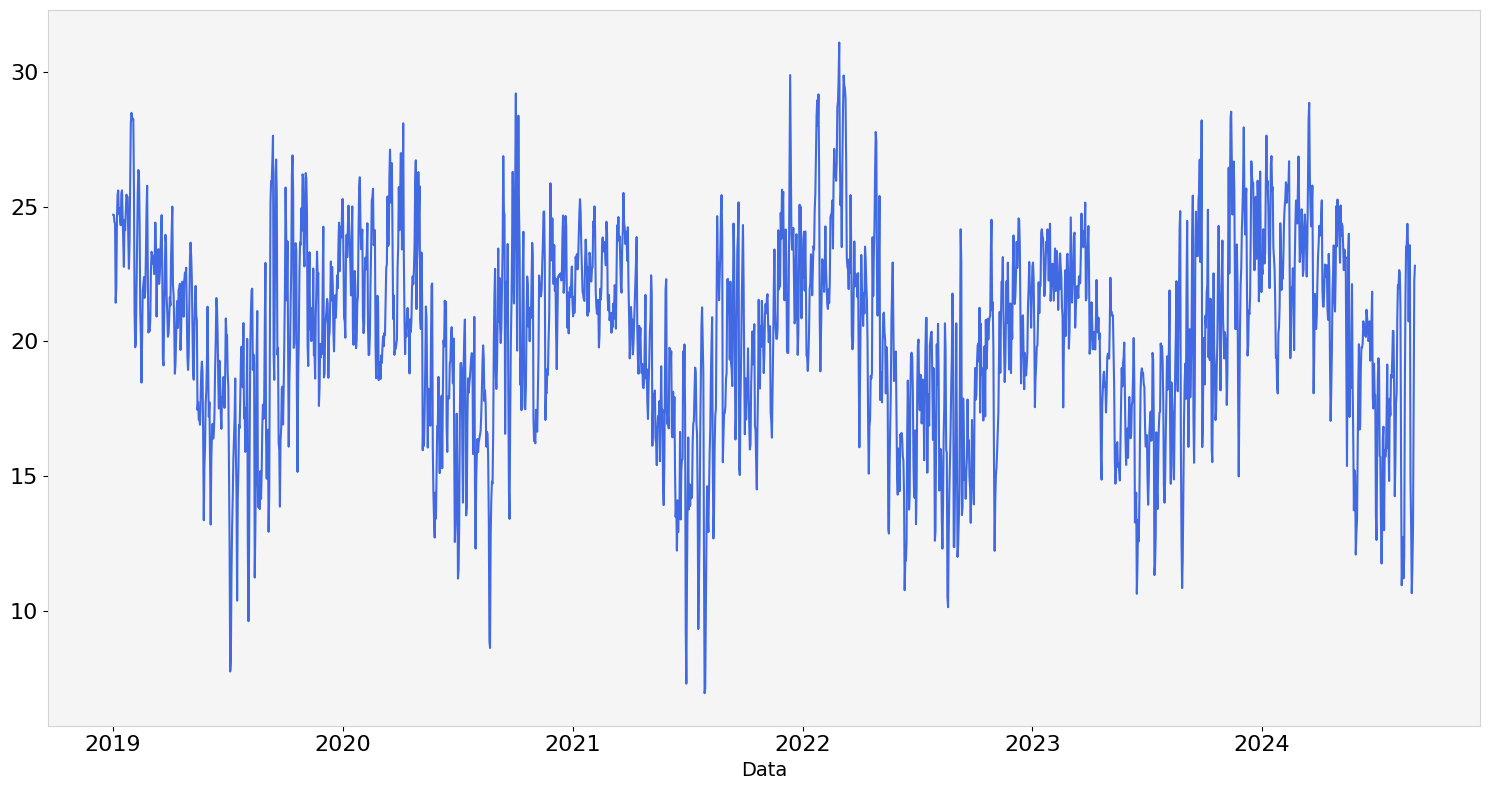

In [70]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(
    df_diario['Data'], 
    df_diario['Temperatura Média Diária (°C)'], 
    linewidth=1.5,
    color='#4169E1'
)
# ax.set_title('Temperatura Média Diária (°C) - Mirante de Santana - São Paulo', fontsize=20)
ax.set_xlabel('Data', fontsize=14)
#ax.grid(True, linestyle='--', alpha=1, color='gray')
ax.set_facecolor(color='whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=16)

#borda
ax.spines['top'].set_color('lightgray')       # Borda superior
ax.spines['right'].set_color('lightgray')     # Borda direita
ax.spines['bottom'].set_color('lightgray')    # Borda inferior
ax.spines['left'].set_color('lightgray')      # Borda esquerda

# ax.spines['top'].set_linewidth(1)         # Espessura da borda superior


plt.tight_layout()
plt.show()

In [78]:
def plot_ax(y, ax, title):
    
    ax.plot(
        df_diario['Data'], 
        y, 
        linewidth=1.5,
        color='#4169E1'
    )
    ax.set_title(title, fontsize=15)
    #ax.set_xlabel('Data', fontsize=14)
    #ax.grid(True, linestyle='--', alpha=1, color='gray')
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=16)

    #borda
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda

    # ax.spines['top'].set_linewidth(1)         # Espessura da borda superior

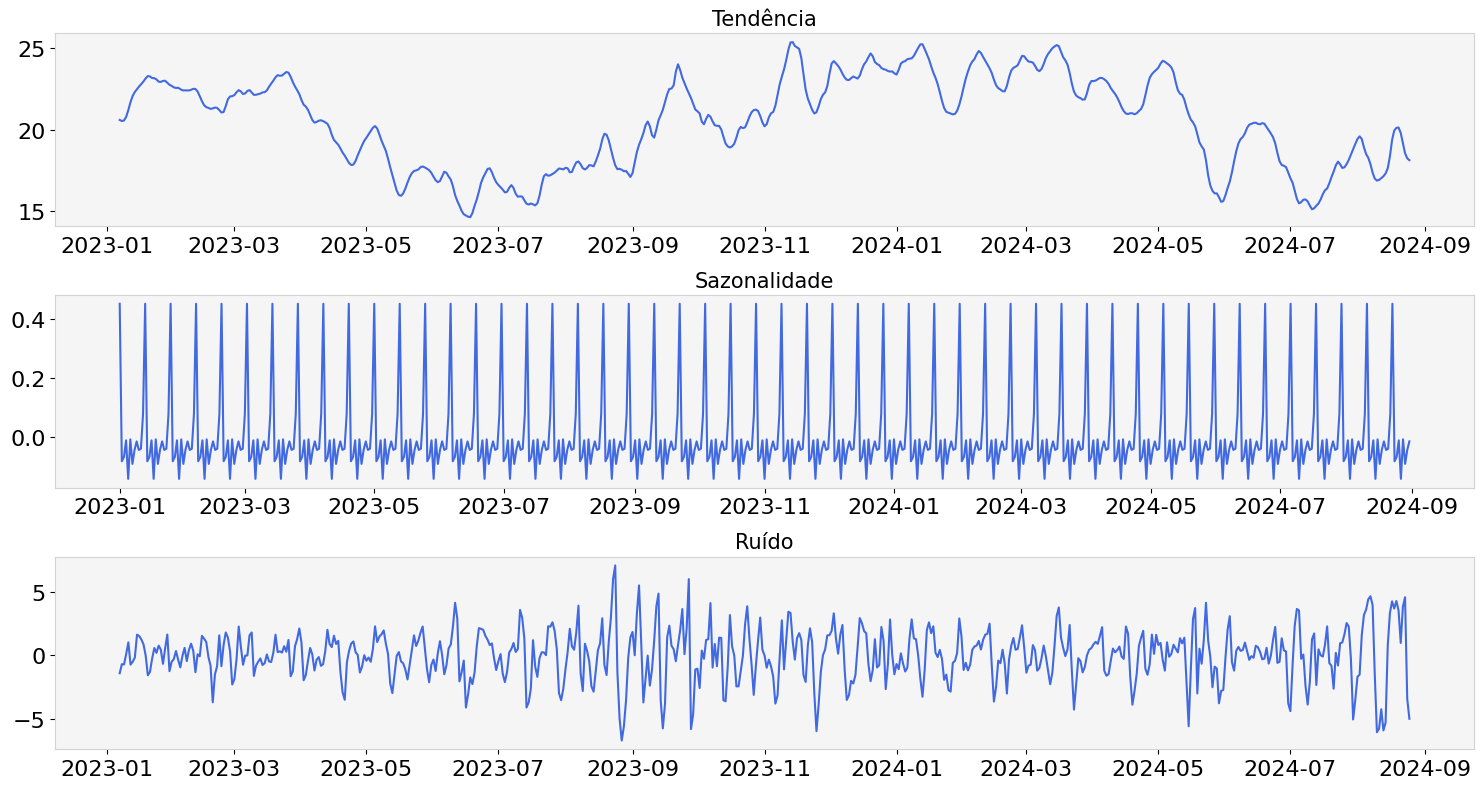

In [72]:
# Correção do Seasonal Decompose e Plots
df_decomp = df_diario[df_diario['Data'].dt.date >= date(2023, 1, 1)]
# df_decomp = df_decomp.set_index(pd.to_datetime(df_decomp['Data']))
# df_decomp.index = pd.DatetimeIndex(df_decomp.index, freq='D') 

result = seasonal_decompose(df_decomp['Temperatura Média Diária (°C)'], model='additive', period=12)

# Plotar em tamanho maior
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

#result.observed.plot(ax=ax1)
#plot_ax(result.observed, ax)
plot_ax(result.trend, ax1, "Tendência")
plot_ax(result.seasonal, ax2, "Sazonalidade")
plot_ax(result.resid, ax3, "Ruído")

plt.tight_layout()
plt.show()

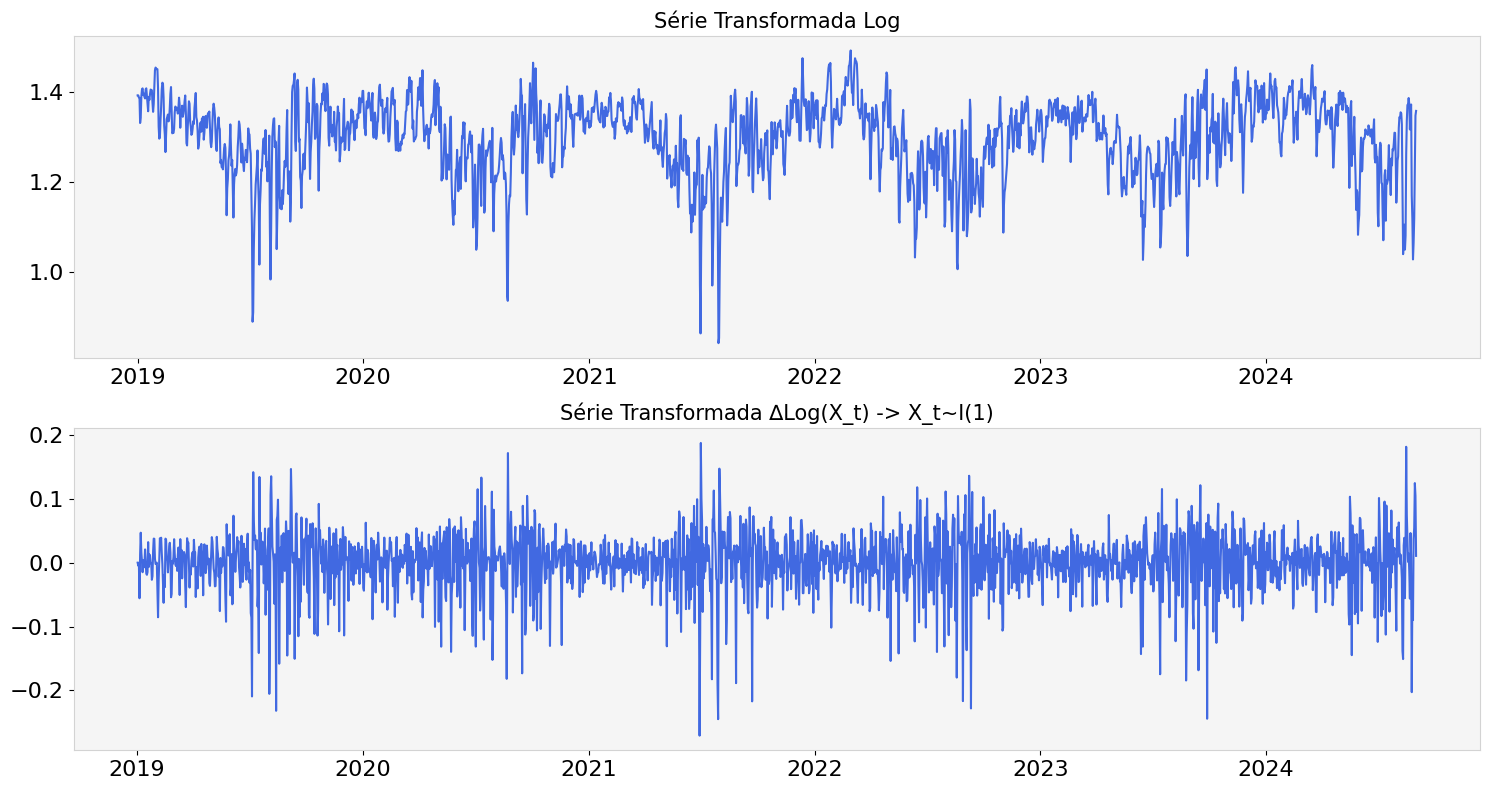

In [90]:
# Transformação Log

df_diario['Temperatura Média Diária (°C) Log'] = np.log10(df_diario['Temperatura Média Diária (°C)'])

#Transformação Diferenciação I~(1) Lag=1

# for i in range(0, len(df_diario)):
#     if i > 5:
#         df_diario.loc[i, 'Log Xt diff Xtmenos1'] = df_diario.iloc[i, 2] - df_diario.iloc[i-5, 2]

df_diario['Log Xt diff 1'] = df_diario['Temperatura Média Diária (°C) Log'].diff(periods=1)

#Plot

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

plot_ax(df_diario['Temperatura Média Diária (°C) Log'], ax1, "Série Transformada Log")
        
plot_ax(df_diario['Log Xt diff 1'], ax2, "Série Transformada ∆Log(X_t) -> X_t~I(1)")

plt.tight_layout()
plt.show()

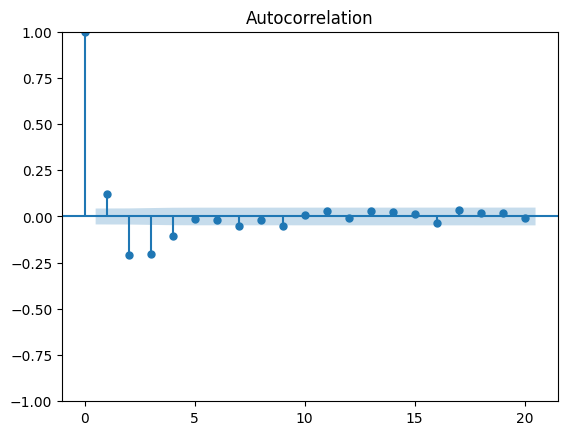

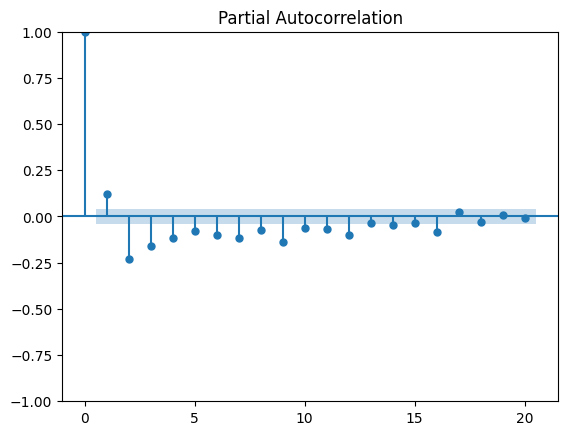

In [91]:
plot_acf(df_diario['Log Xt diff 1'].dropna(), lags=20, alpha=0.05)
plot_pacf(df_diario['Log Xt diff 1'].dropna(), lags=20, alpha=0.05)

plt.show()